In [1]:
from importlib.resources import path
import pathlib
from venv import create
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from glob import glob

In [2]:
data_dir = pathlib.Path('O_or_R')
train_dir = os.path.join(data_dir, 'TRAIN')
train_iu_dir = os.path.join(train_dir, 'O')
train_kwon_dir = os.path.join(train_dir, 'R')

val_dir = os.path.join(data_dir, 'TEST')
val_iu_dir = os.path.join(val_dir, 'O')
val_kwon_dir = os.path.join(val_dir, 'R')

In [3]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(image_count)


25077


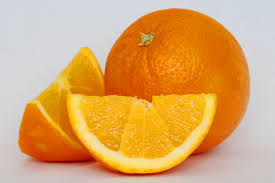

In [4]:
O = list(data_dir.glob('train/O/*.jpg'))
img = PIL.Image.open(str(O[8]))
img

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = image_dataset_from_directory(train_dir,
                                        shuffle = True,
                                        batch_size =batch_size,
                                        image_size =(img_height, img_width))
val_ds = image_dataset_from_directory(val_dir,
                                      shuffle = True,
                                      batch_size = batch_size,
                                      image_size = (img_height, img_width))

Found 22564 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-06 04:03:59.636129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 04:03:59.636476: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2513 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

2022-05-06 04:04:00.990939: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
num_classes = 2

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [9]:
epochs=6
history = model.fit(train_ds,  
          validation_data=val_ds,
          epochs=epochs,) 

Epoch 1/6


2022-05-06 04:05:03.564750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


706/706 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8097

2022-05-06 04:06:45.395244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


706/706 [==============================] - 106s 149ms/step - loss: 0.4343 - accuracy: 0.8097 - val_loss: 0.3752 - val_accuracy: 0.8707
Epoch 2/6
706/706 [==============================] - 98s 139ms/step - loss: 0.3568 - accuracy: 0.8477 - val_loss: 0.3109 - val_accuracy: 0.8766
Epoch 3/6
706/706 [==============================] - 95s 134ms/step - loss: 0.3161 - accuracy: 0.8689 - val_loss: 0.3518 - val_accuracy: 0.8611
Epoch 4/6
706/706 [==============================] - 93s 132ms/step - loss: 0.2759 - accuracy: 0.8868 - val_loss: 0.3136 - val_accuracy: 0.8786
Epoch 5/6
706/706 [==============================] - 95s 134ms/step - loss: 0.2336 - accuracy: 0.9049 - val_loss: 0.3435 - val_accuracy: 0.8842
Epoch 6/6
706/706 [==============================] - 97s 137ms/step - loss: 0.1816 - accuracy: 0.9290 - val_loss: 0.3687 - val_accuracy: 0.8878


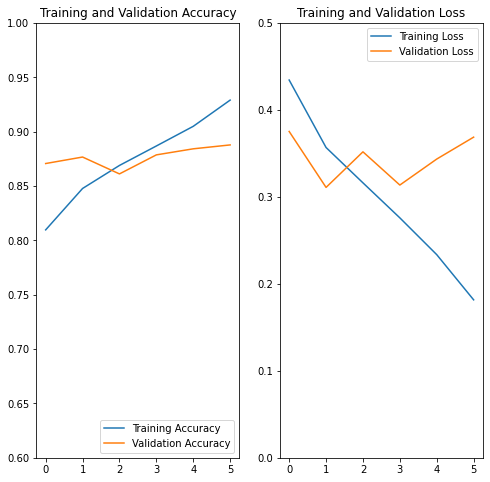

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.6, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0,0.5)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save('my_model/O_R_model.h5')

In [ ]:
pre_img = '/Users/ganghaeseong/Documents/tf/Cnn-classification-TPJ/img0.png'

img = keras.preprocessing.image.load_img(
    pre_img, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)